# **Simulador Robot de Limpieza - M1. Actividad (FJ2023)**
Modelación de sistemas multiagentes con gráficas computacionales (Gpo 101)

20/02/23

Emillio Ortiz Franco - A01194882 

Esteban Martinez - A00831789

<center>
<img src=https://topesdegama.com/app/uploads-topesdegama.com/2022/02/robot-aspiradora-roomba.jpg?x=480&y=375&quality=40 />
</center>














## **Introducción**

El programa implementado hace una visualización de lo que serían los robots tipo Roomba, los cuales limpian una cuadrícula con base a la suciedad que se encuentre. Primero, se tendría que definir el tamaño de la cuadrícula y la posición inicial de cada uno de los robots.

Luego, se implementaría un ciclo que ejecutara los movimientos de los robots en cada paso, siempre y cuando no se cumplan ciertas condiciones de detención (como por ejemplo, que hayan limpiado toda la cuadrícula o que se hayan agotado la batería de los robots (pasos)).

En cada paso, se verificaría si el robot puede moverse a la siguiente posición en la cuadrícula sin chocar con otros robots o salirse de la cuadrícula. Si el movimiento es válido, el robot se movería a la nueva posición y limpiaría la casilla en la que se encuentra, o si no vuelve a buscar una casilla a limpiar. Si el movimiento no es válido, el robot no se mueve y simplemente limpia la casilla en la que se encuentra.

Una vez que se hayan ejecutado todos los pasos para cada robot, el programa mostrará el estado final de la animación por medio que se pueda observar si se limpió por completo la cuadricula.



## **Instalación de Mesa**

In [379]:
!python3 -m pip install mesa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importación de paquetes**

In [380]:
from matplotlib.colors import ListedColormap
from mesa import Agent, Model
from mesa.space import SingleGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector
import random as rm
from math import log10, dist
import numpy as np
import time  
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"
mlp.rcParams['animation.embed_limit'] = 2**128

## **Implementación de la clase Floor**
Modelo que representa el suelo de la habitación a limpiar. 

In [381]:
def random_list(inf, sup, n): 
    return np.random.default_rng().choice(np.arange(inf, sup+1), n, replace=False)

class Floor(Model): 
    def __init__(self, width, height, num_cleaners, num_dirt, cleaner_rad = 1): 
        self.rem_dirt = num_dirt # El número de celdas sucias restantes en el habitación. 
        self.schedule = SimultaneousActivation(self)
        self.grid = SingleGrid(width, height, False)
        self.data_collector = DataCollector(model_reporters={'floor': self.get_grid, 'num_dirt': self.get_rem_dirt}) 

        self.populate(num_cleaners, num_dirt, cleaner_rad)

    def populate(self, num_cleaners, num_dirt, cleaner_rad): 
        cleaners_positions = zip([0] * (self.grid.width-1), random_list(0, self.grid.width-1, num_cleaners))

        for cleaner_pos in cleaners_positions: 
            cleaner = Cleaner(cleaner_pos, self, 100, cleaner_rad) # El robot puede realizar únicamente 100 movimientos. 
            self.grid.place_agent(cleaner, cleaner_pos)
            self.schedule.add(cleaner)
        
        for _ in range(num_dirt): 
            empty_pos = self.grid.find_empty()
            dirt = Dirt(empty_pos, self)
            self.grid.place_agent(dirt, empty_pos)
            self.schedule.add(dirt)

    # Regresa la matrícula de la simulación, con los estados de las celdas convertidos a números enteros. 
    # None = 0, Dirt = 1, Cleaner = 2.  
    def get_grid(self):
        agent_transform = lambda cell: 2 if isinstance(cell, Cleaner) else 1 if isinstance(cell, Dirt) else 0
        return [list(map(agent_transform, row)) for row in self.grid.grid]

    def get_rem_dirt(self): 
        return self.rem_dirt

    def step(self):
        self.data_collector.collect(self)
        self.schedule.step()

## **Implementación de la clase Cleaner**
Agente, representa un robot de limpieza. 

In [382]:
class Cleaner(Agent): 
    def __init__(self, pos, model, moves_left = 100, radius = 1): 
        super().__init__(pos, model)

        self.pos = pos
        self.prev_pos = None # La posición previa del robot. Se mantiene para evitar que el robot 
        # regrese a su posición del paso anterior. 
        self.next_pos = None
        self.radius = radius # Determina el radio del 'sensor' del robot, el número de celdas
        # que puede analizar a la vez en una dirección. 
        self.moves_left = moves_left # La 'batería' del robot: el número de movimientos que puede realizar antes de
        # volverse permanentemente inmóvil. 

    # Regresa la siguiente idónea o aleatoria posición del agente, en la forma de una tupla con dos elementos. 
    def choose_next_pos(self): 
        if self.moves_left <= 0: 
            return self.pos
        
        dirt_pos = self.find_dirt_pos()

        if dirt_pos is None: 
            f_neighborhood = list(filter(lambda pos: pos != self.prev_pos,
                                    self.model.grid.get_neighborhood(self.pos, True, False)))
            return rm.choice(f_neighborhood)
        else: 
            return self.aproximate(dirt_pos)
        
    # Encuentra la posición de la suciedad más cercana al agente. Regresa None si no hay suciedad en la vecinidad. 
    def find_dirt_pos(self):
        neighbors = self.model.grid.get_neighbors(self.pos, True, False, radius=self.radius)
        neighbors_pos = list(map(lambda _agt: _agt.pos, filter(lambda agt: isinstance(agt, Dirt), neighbors)))

        return self.closest_pos(neighbors_pos) if neighbors_pos else None

    # Dada una secuencia de posiciones, regresa la que está más cerca de la posición actual del agente. 
    def closest_pos(self, positions): 
        min_index = 0
        min = dist(self.pos, positions[min_index])

        for i in range(1, len(positions)): 
            dis = dist(self.pos, positions[i])
            if dis < min:
                min_index = i
                min = dis

        return positions[min_index]

    # Produce la posición óptima y adyacente al agente, que mejor lo acerca a la posición dirt_pos. 
    def aproximate(self, dirt_pos): 
        smllr = lambda x, y: 1 if x < y else (-1 if x > y else 0)
        return self.pos[0] + smllr(self.pos[0], dirt_pos[0]), self.pos[1] + smllr(self.pos[1], dirt_pos[1])

    def step(self):
        self.next_pos = self.choose_next_pos()

    def advance(self):
        obj_in_cell = self.model.grid[self.next_pos[0]][self.next_pos[1]]
        if not isinstance(obj_in_cell, Cleaner): 
            if isinstance(obj_in_cell, Dirt): 
                self.model.grid.remove_agent(obj_in_cell)
                self.model.rem_dirt -= 1
            self.prev_pos = self.pos
            self.moves_left -= 1
            self.model.grid.move_agent(self, self.next_pos)

## **Implementación de la clase Dirt**
Agente, una suciedad a limpiar en la matrícula de la habitación. 

In [383]:
class Dirt(Agent): 
    def __init__(self, pos, model): 
        super().__init__(pos, model)
        self.pos = pos

## **Ejecución #1 de la simulación**
La ejecución tiene una duración máxima de 30 segundos o 50 pasos, y se realiza con los siguientes valores para sus parámetros: 
- Dimensiones de la habitación: 25x25
- Número de robots de limpieza: 5
- Número de celdas sucias: 60
- Radio del 'sensor' de los robots: 1



In [384]:
width = 25 
height = 25 
num_cleaners = 5
num_dirt = 60 
cleaner_sensor_radius = 1 

num_gen = 50 
gen_counter = 0
max_duration = 30 
initial_time = time.time()

floor = Floor(width, height, num_cleaners, num_dirt, cleaner_sensor_radius)

while gen_counter <= num_gen and time.time() - initial_time < max_duration: 
  floor.step()
  gen_counter += 1

print(f'Duración de la simulación (segundos): {time.time() - initial_time}')
print(f'Número final de celdas sucias: {floor.get_rem_dirt()} ({(floor.get_rem_dirt()/num_dirt)*100}%)')

simul_data = floor.data_collector.get_model_vars_dataframe()

Duración de la simulación (segundos): 0.1114809513092041
Número final de celdas sucias: 28 (46.666666666666664%)


## **Animación de la ejecución #1**
Los colores en la matrícula tienen los siguientes significados: 

- **Blanco**: espacio vacío. 
- **Negro**: suciedad. 
- **Azul**: robot de limpieza.

In [385]:
%%capture

fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(simul_data['floor'].iloc[0], cmap=ListedColormap(['w', 'k','b']))

def animate(i):
  patch_grid.set_data(simul_data['floor'].iloc[i])

anim = FuncAnimation(fig, animate, frames=num_gen) 

In [386]:
anim

## **Ejecución #2 de la simulación**

Se utiliza en esta segunda ejecución un radio mayor para los 'sensores' de los robots, de 10. Los demás valores de los parámetros son iguales que los de la ejecución #1. 

In [387]:
width = 25 
height = 25 
num_cleaners = 5
num_dirt = 60
cleaner_sensor_radius = 10 

num_gen = 50
gen_counter = 0
max_duration = 30
initial_time = time.time()

floor_2 = Floor(width, height, num_cleaners, num_dirt, cleaner_sensor_radius)

while gen_counter <= num_gen and time.time() - initial_time < max_duration: 
  floor_2.step()
  gen_counter += 1

print(f'Duración de la simulación (segundos): {time.time() - initial_time}')
print(f'Número final de celdas sucias: {floor_2.get_rem_dirt()} ({(floor_2.get_rem_dirt()/num_dirt)*100}%)')

simul_data_2 = floor_2.data_collector.get_model_vars_dataframe()

Duración de la simulación (segundos): 0.2760436534881592
Número final de celdas sucias: 2 (3.3333333333333335%)


## **Animación de la ejecución #2**

In [388]:
%%capture

fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(simul_data_2['floor'].iloc[0], cmap=ListedColormap(['w', 'k','b']))

def animate(i): 
  patch_grid.set_data(simul_data_2['floor'].iloc[i])

anim = FuncAnimation(fig, animate, frames=num_gen) 

In [389]:
anim

## **Comparación de los resultados de las ejecuciones #1 y #2**

Esta comparación analiza la incidencia sobre la simulación del valor del radio de los sensores de los robots. 


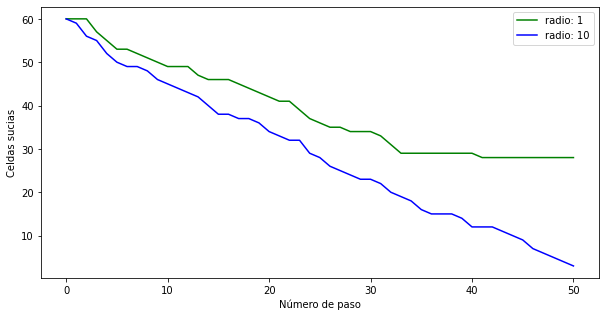

In [390]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.set_xlabel('Número de paso')
axs.set_ylabel('Celdas sucias')

plt.plot(simul_data['num_dirt'], 'g',label='radio: 1')
plt.plot(simul_data_2['num_dirt'], 'b', label='radio: 10')

axs.legend()

plt.show()

La productividad de los robots es altamente mayor cuando su percepción de su entorno es más amplia, ya que un mayor conocimiento sobre sus alrededores les permite hacer con mayor frecuencia movimientos direccionados y eficientes hacia la suciedad, y no aleatorios.  

## **Ejecución #3 de la simulación**
En esta tercera ejecución del modelo, se modifica el número de robots de limpieza (de 5 a 20), los demas valores de los parámetros son identicos a los de la ejecución #1. 


In [391]:
width = 25 
height = 25 
num_cleaners = 20 
num_dirt = 60
cleaner_sensor_radius = 1 

num_gen = 50
gen_counter = 0
max_duration = 30
initial_time = time.time()

floor_3 = Floor(width, height, num_cleaners, num_dirt, cleaner_sensor_radius)

while gen_counter <= num_gen and time.time() - initial_time < max_duration: 
  floor_3.step()
  gen_counter += 1

print(f'Duración de la simulación (segundos): {time.time() - initial_time}')
print(f'Número final de celdas sucias: {floor_3.get_rem_dirt()} ({(floor_3.get_rem_dirt()/num_dirt)*100}%)')

simul_data_3 = floor_3.data_collector.get_model_vars_dataframe()

Duración de la simulación (segundos): 0.12950706481933594
Número final de celdas sucias: 19 (31.666666666666664%)


## **Animación de la ejecución #3**

In [392]:
%%capture

fig, axs = plt.subplots(1, 1, figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])

patch_grid = axs.imshow(simul_data_3['floor'].iloc[0], cmap=ListedColormap(['w', 'k','b']))

def animate(i): 
  patch_grid.set_data(simul_data_3['floor'].iloc[i])

anim = FuncAnimation(fig, animate, frames=num_gen) 

In [377]:
anim

## **Comparación de los resultados de las ejecuciones #1 y #3**

Esta comparación analiza la incidencia sobre la simulación del número de robots de limpieza presentes. 


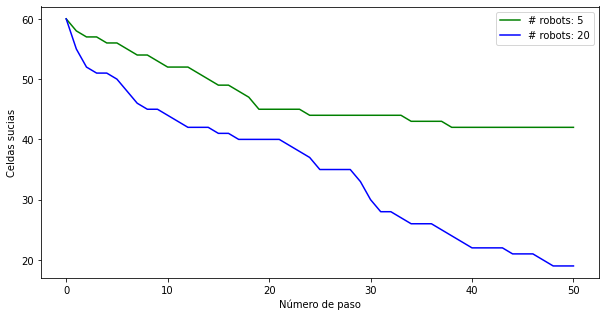

In [378]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))

axs.set_xlabel('Número de paso')
axs.set_ylabel('Celdas sucias')

plt.plot(simul_data['num_dirt'], 'g',label='# robots: 5')
plt.plot(simul_data_3['num_dirt'], 'b', label='# robots: 20')

axs.legend()

plt.show()

Un incremento en el número de robots de limpieza aumenta el número final de celdas limpiadas, pero dicho aumento es inferior al producido por un incremento en el radio de los 'sensores' de los robots, lo que indica que la 'inteligencia' de los robots es más determinante que el número de robots en la simulación.  